In [1]:
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
import crossprob
from tqdm import tqdm
import random
import pickle as pkl

from prompt_risk.bounds import *
from prompt_risk.utils import *

from matplotlib import style
plt.style.use('seaborn-v0_8')

In [27]:
def plot_results(
    dataset = "red_team_chat",
    model_size = "large",
    loss_fn = "toxicity",
    delta = 0.05,
    num_hypotheses = 50,
    beta_min=0.0, 
    beta_max=1.0, 
    metric="var",
    n_cal_list=[200,1000],
):


    pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    load_folder = "../output/{}".format(
        dataset, 
    )
    load_root = "{}/{}_model_{}_{}_loss_dist.pkl".format(
        load_folder,
        dataset, 
        model_size, 
        loss_fn
    )
    print("loading from", load_root)
    
    with open(load_root, 'rb') as file:
        res = pkl.load(file)
    
    bj_bounds = dict()
    correction = delta/num_hypotheses

    n_plots = len(n_cal_list)

    plt.rcParams["figure.figsize"] = [5*n_plots,3]

    fig, axs = plt.subplots(1,n_plots)

    for n_idx, n_cal in enumerate(n_cal_list):
    
        stats = []
        
        for instruction, X in res:
               
            X_cal = X[:n_cal]
            X_test = X[n_cal:]
            n_test = X_test.shape[0]
            assert X_cal.shape[0] == n_cal and X_test.shape[0] == n_test
        
            if X_cal.shape[0] not in bj_bounds:
                b = berk_jones_bound(n_cal, correction)
                bj_bounds[n_cal] = b
            else:
                b = bj_bounds[n_cal]
            
            t_cal = np.linspace(0.0, 1.0, n_cal)
            X_cal_sorted = np.sort(X_cal, axis=-1)
            
            t_test = np.linspace(0.0, 1.0, n_test)
            X_test_sorted = np.sort(X_test, axis=-1)
            
            mean_bound = integrate_quantiles(np.expand_dims(X_cal, 0), b, beta_min=0.0, beta_max=1.0)[0]
            cvar_bound = integrate_quantiles(np.expand_dims(X_cal, 0), b, beta_min=beta_min, beta_max=beta_max)[0]
            gini_bound = calc_gini(np.expand_dims(X_cal, 0), b)[0]
            
            emp_mean_cal = integrate_quantiles(np.expand_dims(X_cal, 0), t_cal, beta_min=0.0, beta_max=1.0)[0]
            emp_cvar_cal = integrate_quantiles(np.expand_dims(X_cal, 0), t_cal, beta_min=beta_min, beta_max=beta_max)[0]
            
            emp_mean_test = integrate_quantiles(np.expand_dims(X_test, 0), t_test, beta_min=0.0, beta_max=1.0)[0]
            emp_cvar_test = integrate_quantiles(np.expand_dims(X_test, 0), t_test, beta_min=beta_min, beta_max=beta_max)[0]

            stats.append([instruction, mean_bound, cvar_bound, gini_bound, emp_mean_cal, emp_cvar_cal, emp_mean_test, emp_cvar_test])

            # plt.plot(X_cal_sorted, b, label="bound")
            # plt.plot(X_cal_sorted, t_cal, label="empirical (cal)")
            # plt.plot(X_test_sorted, t_test, label="empirical (test)")
            # plt.legend()
            # plt.show()
        
            # print("bound mean", mean_bound, "| bound cvar", cvar_bound)
            # print("emp mean (cal)", emp_mean_cal, "| emp cvar (cal)", emp_cvar_cal)
            # print("emp mean (test)", emp_mean_test, "| emp cvar (test)", emp_cvar_test)
            # print()
            # print()
        
        x_plot = []
        y_plot = []
        
        
        for s in stats:
        
            instruction, mean_bound, cvar_bound, gini_bound, emp_mean_cal, emp_cvar_cal, emp_mean_test, emp_cvar_test = s
        
            x_plot.append(emp_mean_cal)
            if metric == "gini":
                y_plot.append(gini_bound)
            elif "var" in metric:
                y_plot.append(cvar_bound)
            else:
                raise ValueError
        
        axs[n_idx].scatter(x_plot, y_plot, alpha=0.8, color=pal[1], label="Prompt")
        
        axs[n_idx].set_xlabel("Empirical Mean on Val. Set", fontsize=14)
        
        
        if metric == "var" and beta_max == 1:
            axs[n_idx].set_title(r"CVaR ($n={}, \beta={}$)".format(n_cal, beta_min), fontsize=14)
        elif metric == "var":
            axs[n_idx].set_title(r"VaR-Interval ($n={}, \beta_l={}, \beta_u={}$)".format(n_cal, beta_min, beta_max), fontsize=14)
        elif metric == "gini":
            axs[n_idx].set_title(r"Gini Co-efficient ($n={}$)".format(n_cal), fontsize=14)
        elif metric == "mean-var":
            axs[n_idx].set_title(r"Mean ($n={}$)".format(n_cal), fontsize=14)

        if n_idx == 1:
            axs[n_idx].legend(fontsize=14, frameon = 1, facecolor='white', framealpha=0.5)
        else:
            axs[n_idx].set_ylabel("Bound", fontsize=14)

    plt.savefig("../plots/{}_{}_{}_{}_{}_{}.png".format(dataset, model_size, loss_fn, beta_min, beta_max, metric), bbox_inches="tight")
    plt.show()
        
            

loading from ../output/xsum/xsum_model_base_bertscore_loss_dist.pkl


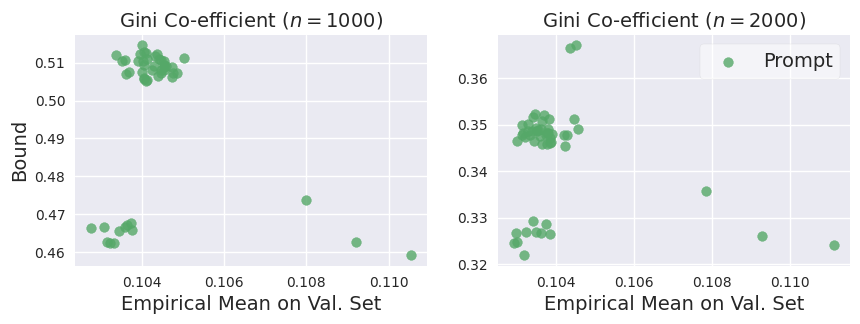

In [28]:
plot_results(
    dataset = "xsum",
    model_size = "base",
    loss_fn = "bertscore",
    metric="gini",
    n_cal_list = [1000, 2000],
)

loading from ../output/red_team_chat/red_team_chat_model_large_toxicity_loss_dist.pkl


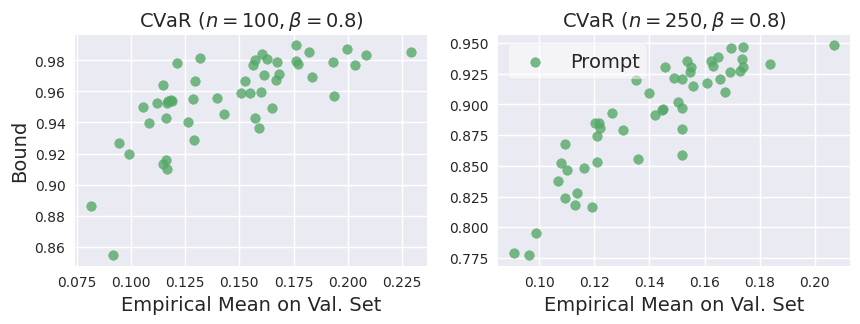

In [29]:
plot_results(
    dataset = "red_team_chat",
    model_size = "large",
    loss_fn = "toxicity",
    beta_min = 0.8,
    beta_max = 1.0, 
    n_cal_list = [100, 250]
)


loading from ../output/full_chat/full_chat_model_base_toxicity_loss_dist.pkl


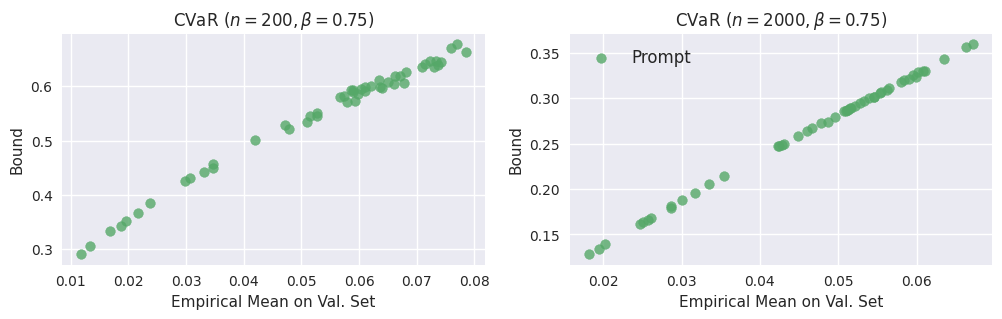

In [5]:
plot_results(
    dataset = "full_chat",
    model_size = "base",
    loss_fn = "toxicity",
    # metric = "mean-var",
    beta_min = 0.75,
    beta_max = 1.0, 
    n_cal_list = [200, 2000]
)